In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn  # nn contains all of PyTorch's building blocks for neural networks
from torch.utils.data import DataLoader # we need DataLoader to feed image into model
import matplotlib.pyplot as plt
from torchmetrics import Accuracy

from torchvision import datasets, transforms

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [3]:
# helper function to show an image

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

#### Configure the device to use Metal Acceleration if available... and set the random state seed

In [4]:
device = torch.device('mps') if torch.backends.mps.is_available() else 'cpu'  # metal acceleration

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device

device(type='mps')

### First, we need to load our dataset and split it into train and test sets

In [5]:
### LOAD THE IMAGE DATA



transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])
PATH = '../data'

TRAIN_PATH = PATH + '/train'
training_set = datasets.ImageFolder(TRAIN_PATH, transform=transform)
training_loader = DataLoader(training_set, batch_size=32, shuffle=True)

VAL_PATH = PATH + '/val'
validation_set = datasets.ImageFolder(VAL_PATH, transform=transform)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)

TEST_PATH = PATH + '/test'
testing_set = datasets.ImageFolder(TEST_PATH, transform=transform)
testing_loaer = DataLoader(testing_set, batch_size=32, shuffle=True)

torch.Size([1, 256, 256])

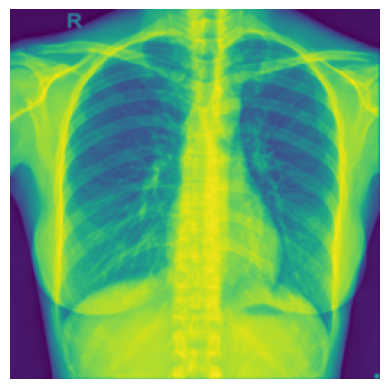

In [6]:
# Run this to test our training data loader
images, labels = next(iter(training_loader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)
images[0].shape

### Let's do some EDA ###

In [7]:
# shape of the image batch and the labels batch
images.shape, labels.shape

(torch.Size([32, 1, 256, 256]), torch.Size([32]))

In [8]:
# Shape of datasets
print(f"Number of samples of training set: {len(training_set)}")
print(f"Number of samples of validation set: {len(validation_set)}")
print(f"Number of samples of test set: {len(testing_set)}")

Number of samples of training set: 13028
Number of samples of validation set: 761
Number of samples of test set: 1527


In [9]:
# Classes

unique_class = training_set.classes
unique_class

['NORMAL', 'PNEUMONIA', 'TUBERCULOSIS', 'UNKNOWN']

### Now we can start building our model. We will first build a simple baseline model, which will be used as a baseline to compare the results of later models to. We then will build more complex models to try to find the model with the best performance, which could include neural network models without/with non-linearity, CNNs and ResNet.

# 1. Build baseline model¶

## 1.1 Create a timer function

In [10]:
from timeit import default_timer as timer

def train_time(start: float, end: float, device: torch.device = None):

    total_time = end - start
    print(f"Train time on {device}: {total_time: .4f} seconds")

    return total_time

## 1.2 Baseline Model

In [37]:
class BaseModel0(nn.Module):
    def __init__(self, input_size: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),  # Activation function
            # Second layer: hidden_size -> num_classes
            nn.Linear(hidden_units, output_shape)
            # Note: No softmax here; CrossEntropyLoss handles it
        )

    def forward(self, x):
        return self.layer_stack(x)

In [38]:
baseModel = BaseModel0(input_size = 256*256, hidden_units = 100, output_shape = len(unique_class))

baseModel.to(device)

BaseModel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=4, bias=True)
  )
)

## 1.3 loss, optimizer, and accuracy function

In [39]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params = baseModel.parameters(), lr = 0.1)
accuracy_fn = Accuracy(task = 'multiclass', num_classes= 4).to(device)

## 1.4 Functionizing training and testing loops¶

In [40]:
def train(model: nn.Module,
            loader: torch.utils.data.DataLoader,
            loss_fn: nn.Module,
            optimizer: torch.optim.Optimizer,
            accuracy_fn: nn.Module,
            num_epochs: int,
            device_on: torch.device = device):
    for epoch in range(1, num_epochs + 1):
        train_loss = 0
        train_accuracy = 0
        
        model.to(device_on)

        for batch, (X,y) in enumerate(loader):

            X, y = X.to(device_on), y.to(device_on)

            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            train_loss += loss
            
            train_accuracy += accuracy_fn(y_pred, y)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss = train_loss / len(loader)
        train_accuracy = train_accuracy / len(loader)
        
        print(f"Epoch: {epoch} | Train Accuracy: {train_accuracy: .6f} | Train Loss: {train_loss: .6f}")
        
        
        

def test(loader: torch.utils.data.DataLoader,
           model: nn.Module,
           loss_fn: nn.Module,
           accuracy_fn: nn.Module,
           device_on: torch.device = device):

    test_loss = 0
    test_accuracy = 0
    model.to(device_on)

    model.eval()

    with torch.inference_mode():
        for X, y in loader:
            
            X, y = X.to(device_on), y.to(device_on)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            
            test_accuracy += accuracy_fn(test_pred, y)
            
        test_loss /= len(loader)
        test_accuracy /= len(loader)

        print(f"Test Accuracy: {test_accuracy: .6f} | Test Loss: {test_loss: .6f}")
    

## 1.5 Training and Testing¶

In [41]:
torch.manual_seed(42)

train_start_time = timer()

train(baseModel,
      training_loader,
      loss_fn,
      optimizer,
      accuracy_fn,
      3,
      device)

train_end_time = timer()
total_train_time_model_0 = train_time(start=train_start_time, 
                                           end=train_end_time,
                                           device=str(next(baseModel.parameters()).device))

Epoch: 1 | Train Accuracy:  0.353937 | Train Loss:  2.999990
Epoch: 2 | Train Accuracy:  0.358532 | Train Loss:  1.293836
Epoch: 3 | Train Accuracy:  0.357996 | Train Loss:  1.294540
Train time on mps:0:  466.3846 seconds



### NOW WE TRY TO BUILD A RESNET model!
Here's ResNet explained: https://www.youtube.com/watch?v=o_3mboe1jYI&ab_channel=rupertai
- ResNet stands for Residual Network, with residual meaning difference.
- Essentially, instead of trying to get our model to predict the final output, we make it predict the **difference between the input and the correct output**.
- We have to add residual connections (skip connections) that bypasses one or more layers to form residual blocks in order to avoid losing input signal (vanishing gradient problem) in a deep network.


In [ ]:
# Using the pretrained ResNet Model

class GrayscaleResNet(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super(GrayscaleResNet, self).__init__()
        # Load pretrained ResNet18 (or ResNet34, 50, etc.)
        self.resnet = models.resnet18(pretrained=pretrained)
        
        # Modify first conv layer: 1 channel instead of 3
        self.resnet.conv1 = nn.Conv2d(
            in_channels=1,              # Grayscale input
            out_channels=64,            # Same as original
            kernel_size=7, 
            stride=2, 
            padding=3, 
            bias=False
        )
        
        # Modify final fully connected layer: 4 classes instead of 1000
        self.resnet.fc = nn.Linear(
            in_features=self.resnet.fc.in_features,  # 512 for ResNet18
            out_features=num_classes
        )
    
    def forward(self, x):
        return self.resnet(x)  # Output: [batch_size, 4]

# Instantiate
model = GrayscaleResNet(num_classes=4, pretrained=True)
print(model)